# Train cellpose on watershed segmentations

In [1]:

import skimage, scipy

import matplotlib.pyplot as plt

import sys; sys.path += [".."]  # NOTE find shared modules

from util.preprocess import *
from util.plot import *
from util.onnx import *

import segmentation_models_pytorch as smp
import torch

def norm(x): return (x - x.min()) / (x.max() - x.min())

CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if CUDA else 'cpu')

print(f"Device: {device}")

/gpfs/space/home/eckhardt/.micromamba/envs/smp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda:0


<Axes: title={'center': 'Input image (green channel): third/1'}>

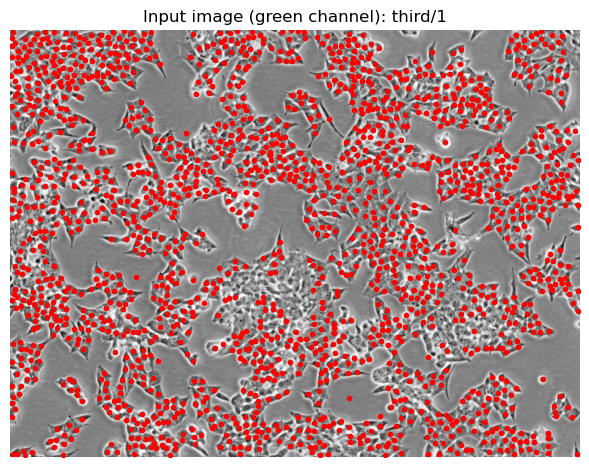

In [2]:

dataset = 'third'
imgid = '1'

SLICE = False if CUDA else 512

RGB = norm(skimage.io.imread(f"../data/{dataset}/{imgid}.jpg").astype(np.float32))
if SLICE: RGB = RGB[:SLICE, :SLICE]

# green channel turned out to be the sharpest
G = RGB[..., 1]

pos = preprocess_point("../data/third/points.json")
if SLICE: pos = np.array([[x,y] for x,y in pos if 0 <= x < SLICE and 0 <= y < SLICE])

ax = plot_image(G, title=f"Input image (green channel): {dataset}/{imgid}")
plot_points(pos, ax, c='r')

2023-12-09 13:32:26.370882896 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 21922, index: 1, mask: {2, 26, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-12-09 13:32:26.371131111 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 21926, index: 5, mask: {6, 30, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-12-09 13:32:26.370948401 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 21924, index: 3, mask: {4, 28, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-12-09 13:32:26.370887785 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 21921, index: 0, mask: {1, 25, }, error code: 22 error msg: Invalid argument. Speci

<Axes: title={'center': 'Mask (fake phase reconstruction, threshold 0.01)'}>

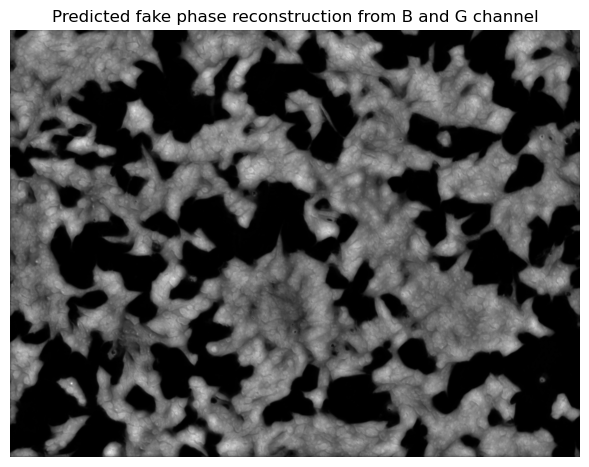

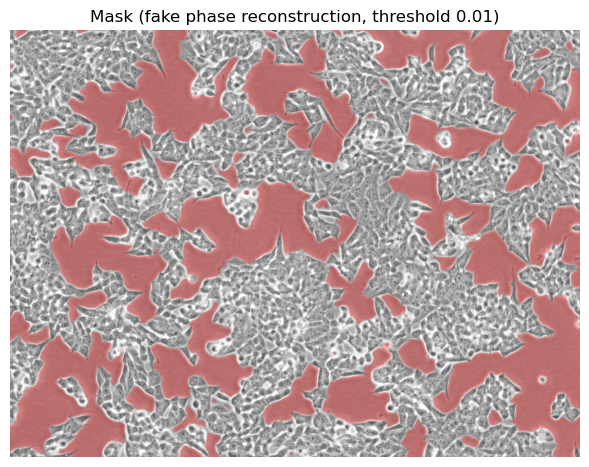

In [3]:



bg_mask_predictor = get_onnx("../data/phaseimaging-combo-v3.onnx")

def bg_mask(thresh):

  input = np.expand_dims(np.transpose(RGB[..., [2, 1]], (2, 0, 1)), axis=0)
  pred = bg_mask_predictor(input)

  mask = (pred[0, 0] > thresh).reshape(G.shape)

  return pred[0,0], mask

thresh = 0.01
fake_phase, bg_mask = bg_mask(thresh=thresh)
plot_image(
  fake_phase, title=f"Predicted fake phase reconstruction from B and G channel"
)
plot_image(
  skimage.color.label2rgb(1 - bg_mask, RGB, bg_color=None, alpha=0.3),
  title=f"Mask (fake phase reconstruction, threshold {thresh:.2f})",
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


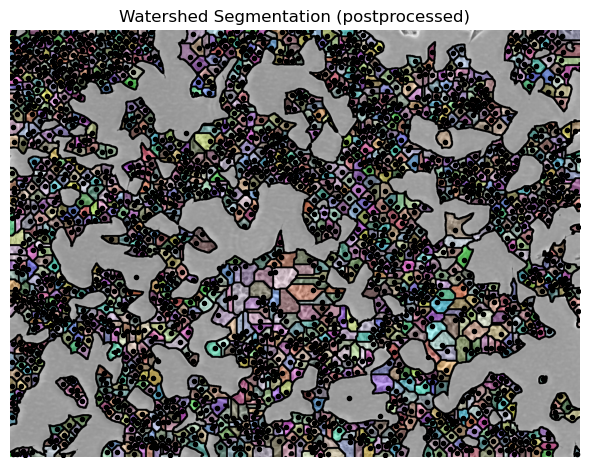

In [4]:

mark = np.zeros(RGB.shape[:2], dtype=int)
mark[pos[:, 0], pos[:, 1]] = np.arange(len(pos)) + 1
# mark[neg[:,0], neg[:,1]] = -1

ws = skimage.segmentation.watershed(bg_mask, mark, mask=bg_mask)
#ws = skimage.morphology.remove_small_holes  (ws, 20)
ws = skimage.morphology.remove_small_objects(ws, 20)

bounds = skimage.segmentation.find_boundaries(ws, mode="thick")

bounds = scipy.ndimage.maximum_filter(bounds, size=6)


plot = skimage.color.label2rgb(ws, G, bg_color=None, alpha=0.4, colors=mk_colors(pos))
plot = skimage.color.label2rgb(bounds, plot, bg_color=None, alpha=1, colors=['black'], saturation=1)
ax = plot_image(plot, title="Watershed Segmentation (postprocessed)")
plot_points(pos, ax, c='k');
del plot

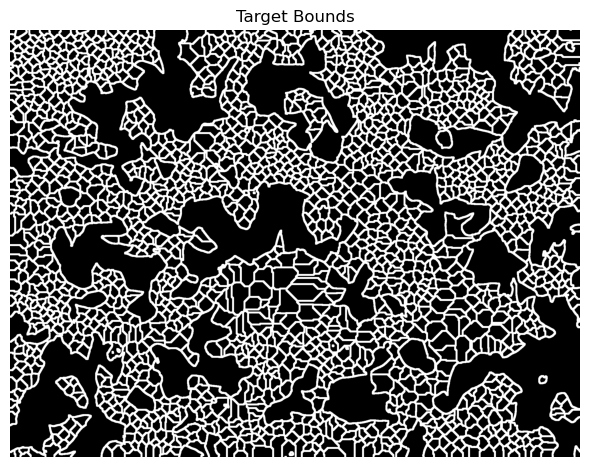

In [5]:
# turn the ws segmentation into a mask with 1 for background, 2 for any cell instance and 3 for the boundaries
target = np.zeros((*ws.shape, 1))
target[..., 0] = bounds


plot_image(target[...,0], title=f"Target Bounds")


# target = G; print("NOTE: using G channel as target") # NOTE change this back TODO
target = torch.from_numpy(np.transpose(target, (2, 0, 1))).unsqueeze(0).float().to(device)  # NOTE that for multiple channels you have to replace the first unsqueeze(0) with permute(2,0,1)
input = torch.from_numpy(np.transpose(RGB, (2, 0, 1))).unsqueeze(0).float().to(device)

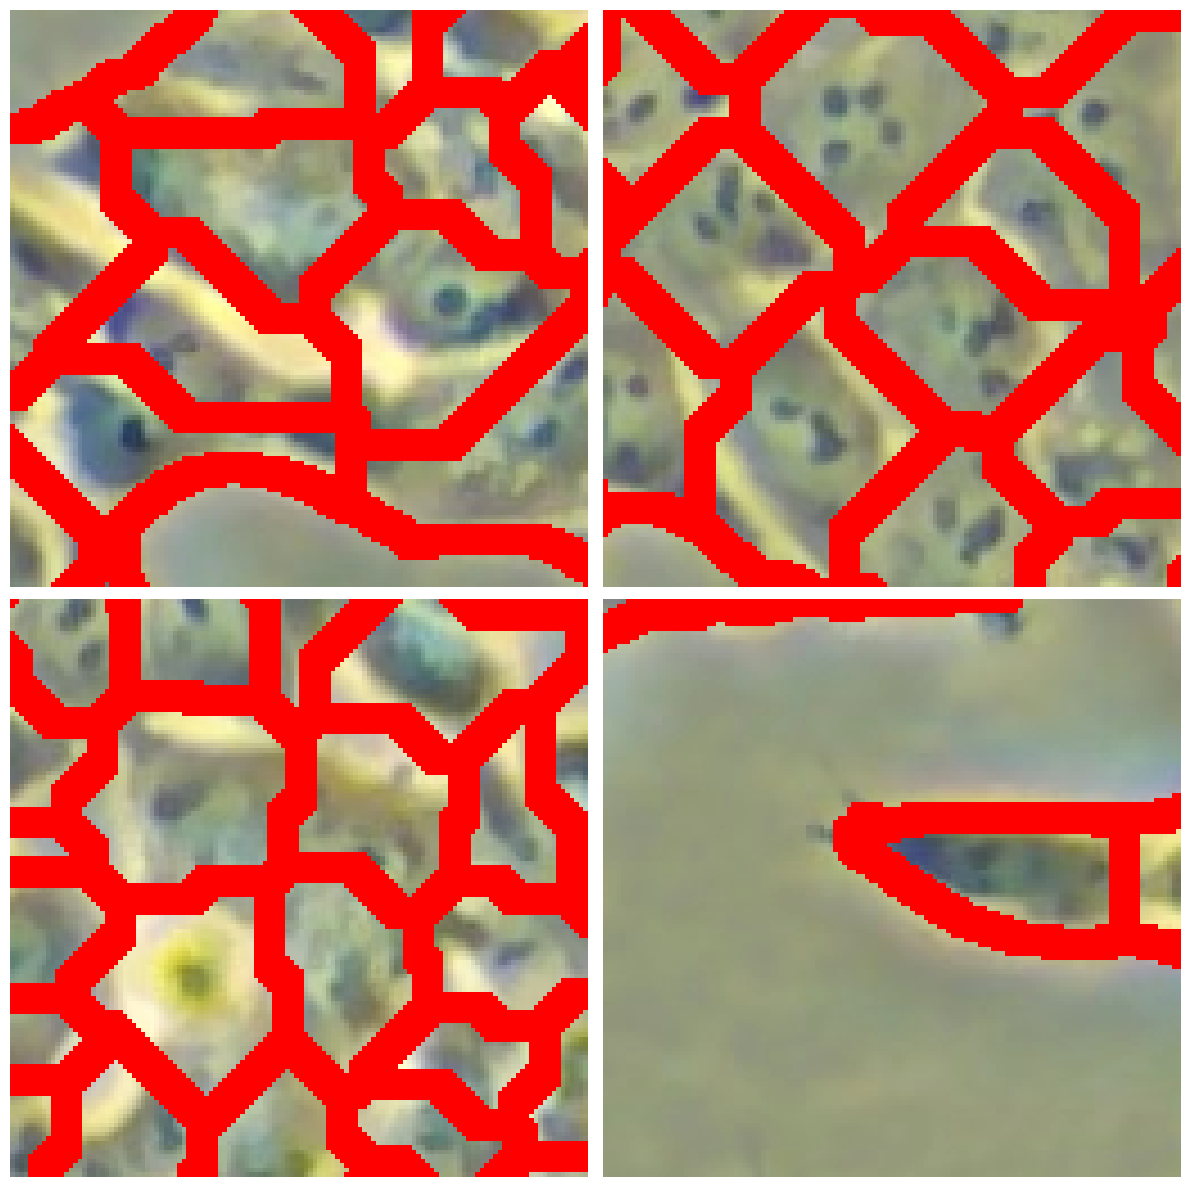

In [6]:

def sample_tile(X, Y, size):
  """Sample a tile of size `size` from the image X and the mask Y"""
  c,h,w = X.shape[-3:]
  x = np.random.randint(0, w - size)
  y = np.random.randint(0, h - size)
  return X[..., y:y+size, x:x+size], Y[..., y:y+size, x:x+size]

def batch_tiles(X, Y, size, n):
  """Sample n tiles of size `size` from the image X and the mask Y"""
  Xs, Ys = zip(*[sample_tile(X, Y, size) for _ in range(n)])
  return torch.stack(Xs), torch.stack(Ys)


# plot a few sampled tiles
fig, axs = mk_fig(2,2, scale=1, shape=(128,128))
for ax in axs:
  X,Y = sample_tile(input, target, 128)

  X,Y = X[0].cpu().numpy(), Y[0].cpu().numpy()
  #y = np.argmax(Y, axis=0)

  heat = norm(np.stack([Y[0],Z:=np.zeros_like(Y[0]),Z,Y[0]], axis=-1))
  
  plot_image(np.transpose(X, (1,2,0)), ax=ax)
  plot_image(heat, ax=ax)

In [7]:
model = smp.Unet(
  encoder_name="resnet34",
  encoder_weights=None,
  in_channels=3,
  classes=1,
  activation='sigmoid',
)
model.to(device)

model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

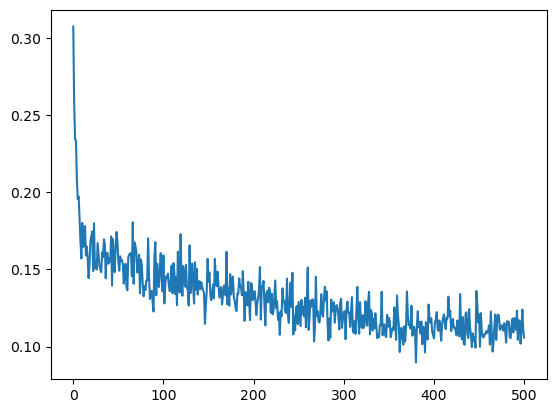

In [8]:

# train the model in a simple pytorch loop
LOG = []

n_epochs = 501 if CUDA else 101
batch_size = 32 if CUDA else 8

optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
criterion = torch.nn.MSELoss()
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.5)

model.train()

for epoch in range(n_epochs):
  model.train()
  optimizer.zero_grad()

  X,Y = batch_tiles(input[0], target[0], 128, batch_size)

  pred = model(X)
  loss = criterion(pred, Y)

  loss.backward()
  optimizer.step()

  if epoch % 1 == 0:
    with torch.no_grad():
      model.eval()
      pred = model(input)

      LOG.append(dict(
        epoch = epoch,
        loss = loss.item(),
        lr = optimizer.param_groups[0]['lr'],
        pred = pred[0].detach().cpu().numpy(),
      ))

  
  scheduler.step()#(loss.item())

losses = np.array([x['loss'] for x in LOG])
plt.plot(losses)

<Axes: >

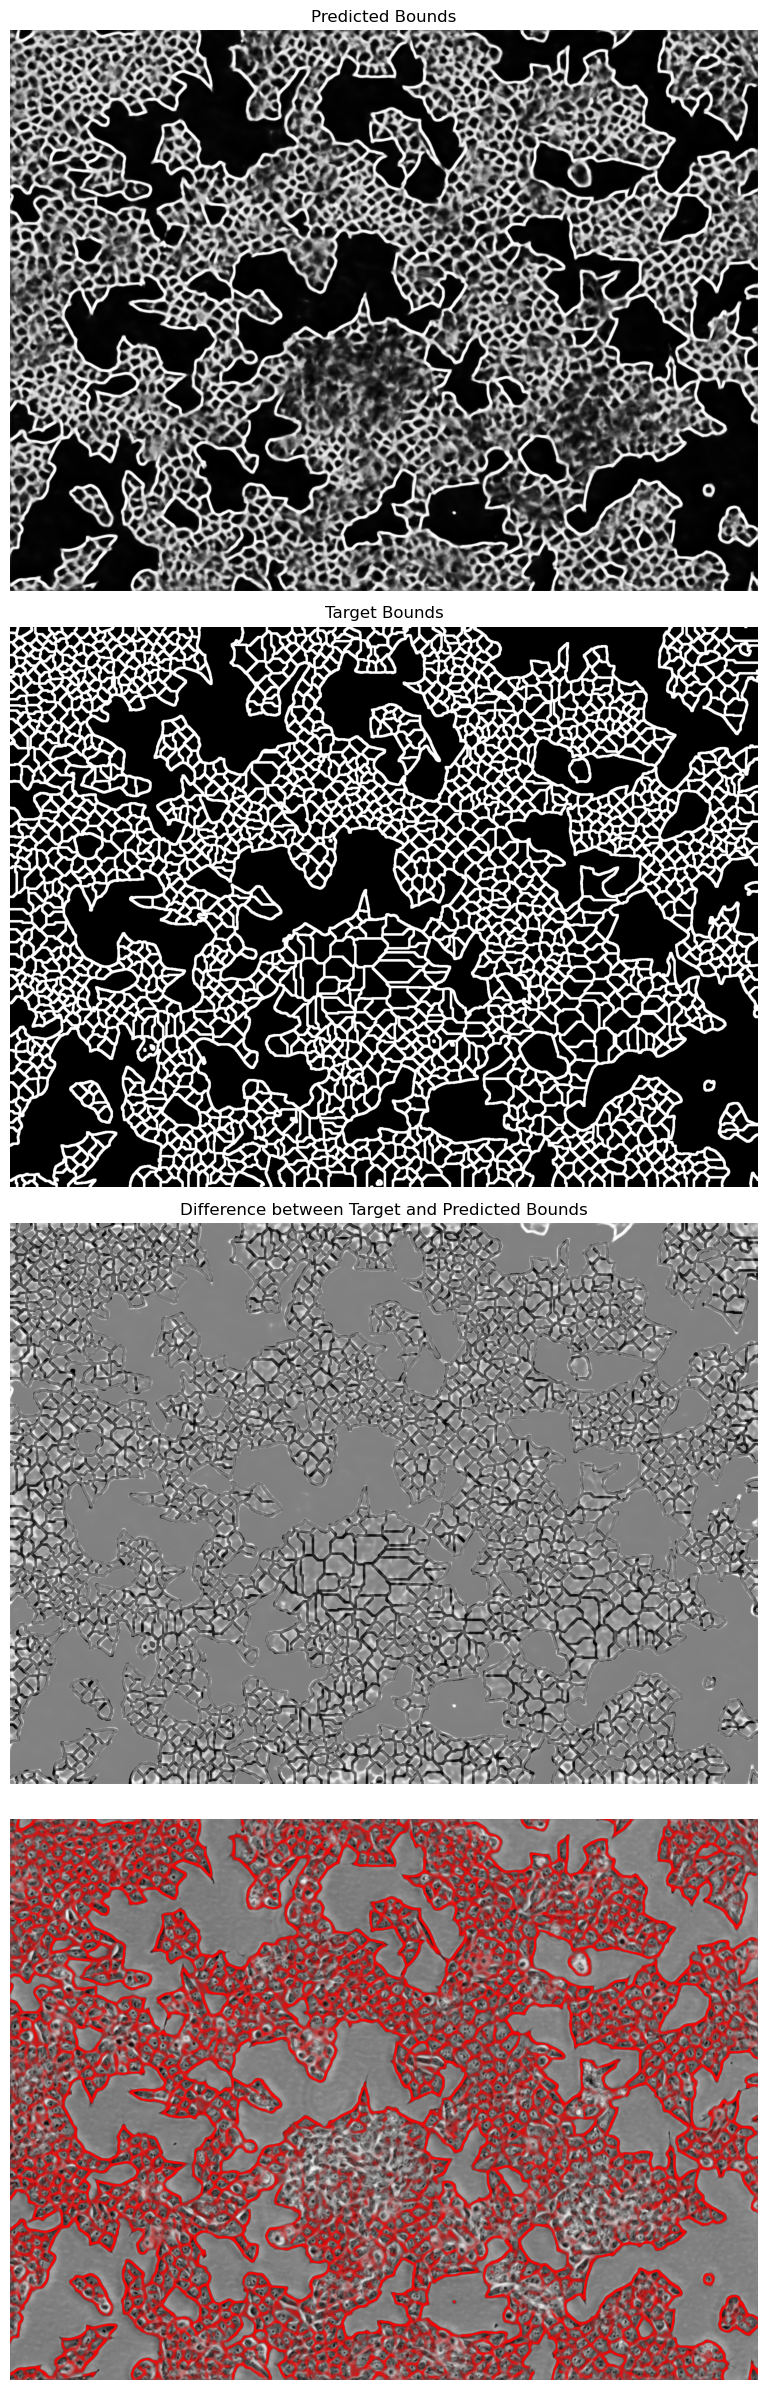

In [9]:

model.eval()
with torch.no_grad():
  pred = model(input).detach().cpu().numpy()[0][0]

fig, axs = mk_fig(1,4, scale=1, shape=target.shape[-2:])

targ = target[0,0].detach().cpu().numpy()
inp = input[0,1].detach().cpu().numpy()

plot_image(pred, ax=axs[0], title=f"Predicted Bounds")
plot_image(targ, ax=axs[1], title=f"Target Bounds")

title = f"Difference between Target and Predicted Bounds"
plot_image(pred-targ, ax=axs[2], title=title)

title = F"Predicted Bounds Overlayed on Image"
heat = norm(np.stack([pred, Z:=np.zeros_like(pred),Z,pred], axis=-1))
plot_image(inp, ax=axs[3], title=title)
plot_image(heat, ax=axs[3])

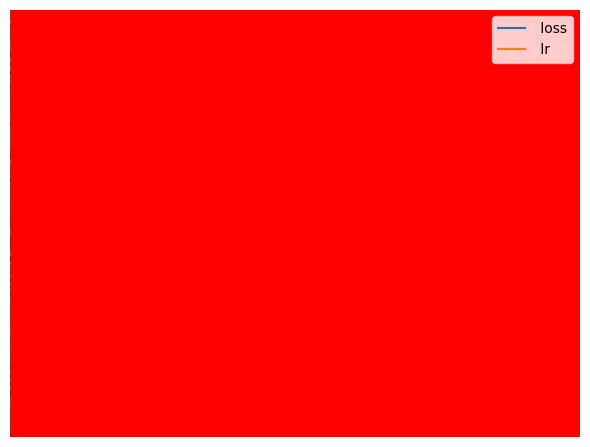

In [10]:

try: 
  import numpy as np
  from matplotlib.animation import FuncAnimation, FFMpegWriter
  from IPython import display
  import matplotlib.pyplot as plt
  import os 
  try: 
    os.system("module load ffmpeg")
  except: 
    print("could not: module load ffmpeg")
    pass

  fig, ax = mk_fig(1,1)

  FRAMES = len(LOG)

  logify = False

  H = target.shape[-2]

  losses, lrs = [ (
    y := np.array([x[dim] for x in LOG]),
    y := np.log(y) if logify else y,
    m := y.min() if logify else 0,
    H - (y - m) / (y.max() - m) * H
    )[-1]
    
    for dim in ['loss', 'lr']
  ]
 
  def animate(i):
    epoch, loss, lr, pred = [LOG[i][k] for k in 'epoch loss lr pred'.split()]
    pred = pred[0]  # only one channel in this case

    H,W = pred.shape

    ax.clear()
    xs = np.linspace(0, W*(i-1)/FRAMES, i)
    ax.plot(xs, losses[:i], label=f"{'log' if logify else ''} loss")
    ax.plot(xs, lrs[:i], label=f"{'log' if logify else ''} lr")

    #plot_image(pred, ax=ax0, title=f"Predicted Bounds")
    title = F"Predicted Bounds Overlayed on Image"
    heat = norm(np.stack([pred, Z:=np.zeros_like(pred),Z,pred], axis=-1))
    plot_image(inp, ax=ax, title=title)
    plot_image(heat, ax=ax)
    ax.legend();


  anim = FuncAnimation(fig, animate, frames=FRAMES, interval=100)
 
  if CUDA:  
    writervideo = FFMpegWriter(fps=30) 
    anim.save('../runs/smp/unet-watershed/training-convergence.mp4', writer=writervideo) 
  else:
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()

except: pass